In [ ]:
!gdown 1Hlqa8bH_OR0AvEv4Mj_M-d2-WKTSKtJJ

Downloading...
From: https://drive.google.com/uc?id=1Hlqa8bH_OR0AvEv4Mj_M-d2-WKTSKtJJ
To: /content/archive.zip
100% 213M/213M [00:01<00:00, 125MB/s]


In [ ]:
!unzip -qq archive.zip

In [ ]:
import os
from glob import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
train = ImageFolder("/content/is that santa/train" , transform = tfm)
test = ImageFolder("/content/is that santa/test" , transform = tfm)




In [ ]:
len_train = len(train)
len_test = len(test)

In [ ]:
print(len_train)
print(len_test)

614
616


In [ ]:
#Mapping the index
train.class_to_idx

{'not-a-santa': 0, 'santa': 1}

In [ ]:
train_loader = DataLoader(train, 
                          batch_size = 30,
                          drop_last = False,
                          shuffle = True)

In [ ]:
test_loader = DataLoader(test,
                        batch_size = 30,
                        drop_last = False,
                        shuffle = False)

In [ ]:
class santa(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size = 3, stride=1,padding=1)
        self.norm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10,20,kernel_size = 3,stride = 1,padding = 1)
        self.norm2 = nn.BatchNorm2d(20)
        self.conv3 = nn.Conv2d(20,40,kernel_size = 3,stride = 1,padding = 1)
        self.norm3 = nn.BatchNorm2d(40)
        self.pool = nn.MaxPool2d(2, 2)
        self.act_fn = nn.ReLU()

        self.linear1 = nn.Linear(40*16*16, 100)
        self.linear2 = nn.Linear(100, num_classes)
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.norm1(self.conv1(x))))
        x = self.pool(F.relu(self.norm2(self.conv2(x))))
        x = self.pool(F.relu(self.norm3(self.conv3(x))))
        x = x.view(-1, 40*16*16)
        x = self.drop(x)
        x = F.relu(self.linear1(x))
        x = self.drop(x)
        x = self.linear2(x)

        return x


In [ ]:
model = santa()
model

santa(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act_fn): ReLU()
  (linear1): Linear(in_features=10240, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=2, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [ ]:
model.to(DEVICE)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)
EPOCHS = 10

In [ ]:
def train_fn(train_loader, model, loss_func, optimizer):
    losses = []
    model.train()

    progress = tqdm(train_loader, total=len(train_loader))
    for i,(imgs, labels) in enumerate(progress):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        y_preds = model(imgs)
        loss = loss_func(y_preds, labels) #loss function created

        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 

        losses.append(loss.item())
        
    return np.mean(losses)

In [ ]:
def test_fn(test_loader,model,loss_func,optimizer):
    losses = []
    model.eval()

    progress = tqdm(test_loader, total=len(test_loader))
    for i,(imgs, labels) in enumerate(progress):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            y_pred = model(imgs)
            loss = loss_func(y_pred,labels)

        losses.append(loss.item())


    return np.mean(losses)
        


In [ ]:
train_losses = []
test_losses = []

best_dict = None
best_loss = np.inf

for ep in range(EPOCHS):
    print('='*5 + f" Epoch {ep+1} " + '='*5)

    tr_loss = train_fn(train_loader, model, loss_func, optimizer)
    ts_loss = test_fn(test_loader, model, loss_func, optimizer)

    # EARLY STOPPING
    if ts_loss < best_loss:
        best_loss = ts_loss
        best_dict = model.state_dict()

    train_losses.append(tr_loss)
    test_losses.append(ts_loss)

    print(f"Epoch {ep} - Train Loss {tr_loss:.4f} - test Loss {ts_loss:.4f}\n")

===== Epoch 1 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.5321 - test Loss 0.9722

===== Epoch 2 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.3561 - test Loss 0.3485

===== Epoch 3 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.3001 - test Loss 0.3134

===== Epoch 4 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.2568 - test Loss 0.2497

===== Epoch 5 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.2408 - test Loss 0.2310

===== Epoch 6 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.2171 - test Loss 0.2579

===== Epoch 7 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.1903 - test Loss 0.2357

===== Epoch 8 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.1981 - test Loss 0.2750

===== Epoch 9 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.1835 - test Loss 0.2270

===== Epoch 10 =====


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.2092 - test Loss 0.2774



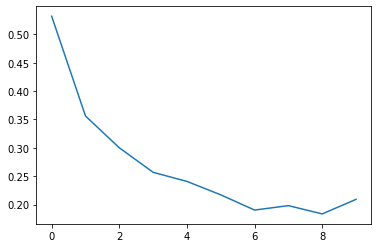

In [ ]:
plt.plot(train_losses)

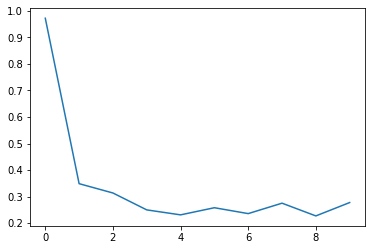

In [ ]:
plt.plot(test_losses)

In [ ]:
model.load_state_dict(best_dict)

<All keys matched successfully>

In [ ]:
test_preds = []
test_trues = []

progress = tqdm(test_loader, total=len(test_loader))
model.eval()

for i, (imgs, labels) in enumerate(progress):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)
    
    with torch.no_grad():
        y_preds = model(imgs)

    pred_labels = np.argmax(y_preds.cpu().detach().numpy(), axis=1)
    test_preds.extend(pred_labels.tolist())
    test_trues.extend(labels.cpu().detach().numpy().tolist())

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
metrics.accuracy_score(test_preds, test_trues)

0.8798701298701299